# Qlearning 

## Import Packages 

In [12]:
import pandas as pd 

%pylab inline --no-import
import pylab as pl
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# file with all qlearning code 
from qlearning_s import * 
# Seaborn options 
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 8)})
plt.style.use('ggplot') # ggplot2 style for matplotlib 


Populating the interactive namespace from numpy and matplotlib


In [13]:
df = pd.read_csv("table.csv")

In [14]:
prices_sp500 = df.loc[:,"Close"].values

In [15]:
prices_sp500

array([ 2060.98999 ,  2064.290039,  2038.969971, ...,  1272.339966,
        1244.780029,  1228.099976])

In [16]:
returns_sp500 = shift(prices_sp500,1)/prices_sp500 - 1

In [17]:
returns_sp500

array([ 0.        , -0.00159864,  0.01241807, ..., -0.00205133,
        0.02214041,  0.013582  ])

In [18]:
model = QlearningNaive(returns_sp500[1:])
model.epsilon =0.01

In [19]:
model.qlearning_step()

state : 0.0, new_state : 1, actions : 1, reward :0.0124180681227, 
Q matrix : 
 [[ 0.  0.]
 [ 0.  0.]]
state : 1, new_state : 1, actions : 1, reward :0.0088167364067, 
Q matrix : 
 [[ 0.          0.00620903]
 [ 0.          0.        ]]
state : 1, new_state : 1, actions : 1, reward :0.0077784022432, 
Q matrix : 
 [[ 0.          0.00620903]
 [ 0.          0.00440837]]
state : 1, new_state : 0, actions : 1, reward :-0.0177972200917, 
Q matrix : 
 [[ 0.          0.00620903]
 [ 0.          0.0069277 ]]
state : 0, new_state : 0, actions : 1, reward :-0.0150405205696, 
Q matrix : 
 [[ 0.          0.00620903]
 [ 0.          0.00222111]]
state : 0, new_state : 1, actions : 1, reward :0.0145149693436, 
Q matrix : 
 [[ 0.          0.00109204]
 [ 0.          0.00222111]]
state : 1, new_state : 1, actions : 1, reward :0.0106185611969, 
Q matrix : 
 [[ 0.          0.00497529]
 [ 0.          0.00222111]]
state : 1, new_state : 1, actions : 1, reward :0.00475555987407, 
Q matrix : 
 [[ 0.          0.0

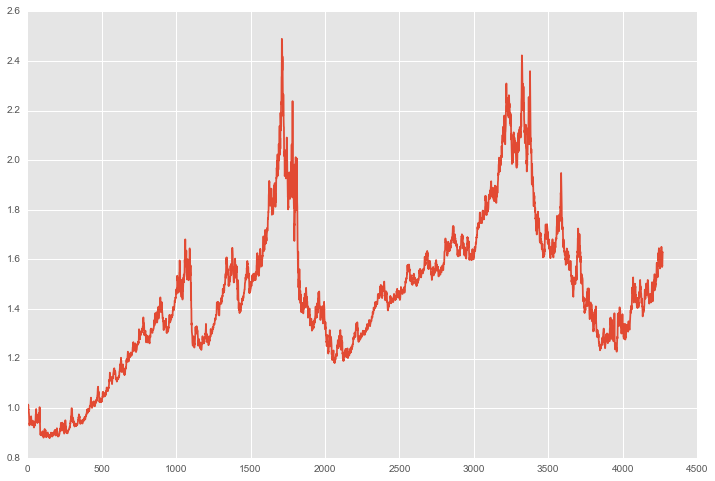

In [20]:
plt.plot((1+model.rewards[1:]).cumprod())

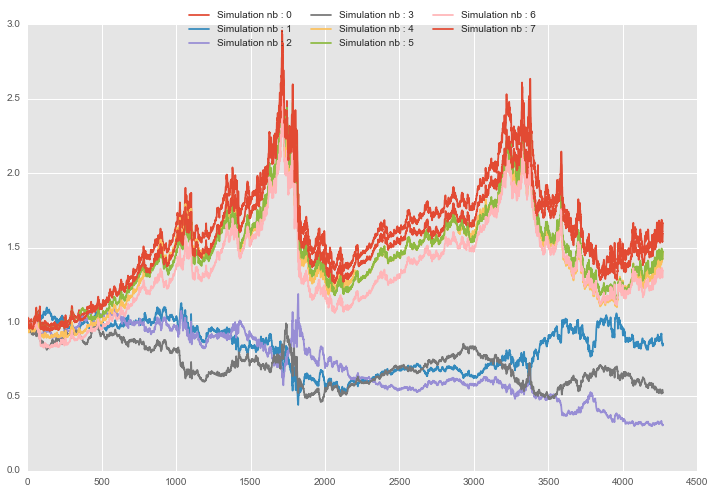

In [21]:
res = model.monte_carlo()

### Convergence of Q matrix

In [23]:
res[1]

array([[[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]],

       [[ 0.00150162,  0.00464754],
        [ 0.00224324,  0.00339936]]])

## Moving Average

In [188]:
model_ma = QlearningFunction(returns_sp500[1:])

In [ ]:
#model_ma.reset()
model_ma.qlearning_step()

In [ ]:
plt.plot((model_ma.rewards + 1).cumprod())

In [ ]:
model2.current_state(-1)

## Conclusion 

* Moving average is a bad solution because with discretization new state will not change 
* So the distinction state short state long is useless 

In [ ]:
model_sharp = QlearningFunction(prices_sp500)
model_sharp.state_function = sharp_ratio_a # annualized sharp ratio function 
#model_sharp.nb_states = 8
model_sharp.bins_discrete = np.linspace(-1, 1, model_sharp.nb_states - 1)

In [ ]:
model_sharp.qlearning_step()

In [ ]:
model_sharp.q

In [ ]:
plt.plot((model_sharp.rewards + 1).cumprod())

In [32]:
np.linspace(-1,1,3)

array([-1.,  0.,  1.])

In [176]:
class Qlearning2state(object):
    def __init__(self,market_returns,nb_states):
        self.market_returns = market_returns
        self.samples = len(self.market_returns)
        self.actions = np.array([0,1,2]) #short, out of market, long
        self.state_function = moving_average
        self.nb_actions = len(self.actions)
        self.nb_states = nb_states
        self.epsilon = 0.05
        self.risk_free_rate = 0
        self.transaction_cost = 0
        self.gamma = 0.95 # discount factor
        self.nmc = 10 # nb of simulations of Monte Carlo
        self.q = np.zeros((self.nb_states,self.nb_states,self.nb_actions))
        self.rewards = np.zeros(self.samples)
        self.bins_discrete = get_discretisation(returns_sp500, self.nb_states + 1) # discretization
        self.nb_visits = np.ones((self.nb_states,self.nb_states,self.nb_actions))

    def reset(self):
        self.nb_visits = np.ones((self.nb_states,self.nb_states,self.nb_actions))
        self.rewards = np.zeros(self.samples)

    def get_reward(self, action,market_return):
        """ Get reward """
        return market_return * action # no transaction cost and risk free rate = 0
    
    def current_state(self, signal):
        """ Discretization of the the continuous states (moving average, sharp ratio) """
        #nb_states is the number of bins here
        return np.sum(self.bins_discrete < float(signal))
                              
    def get_action(self, state_short, state_long):
        # starting point of algorithm 
        if (self.q[state_short, state_long, :]==0).all():
            return np.random.choice(self.actions)
        else:
            #Epsilon-Greedy
            if np.random.random(1) < self.epsilon:
                return np.random.choice(self.actions)
            else:
                return np.argmax(self.q[state_short, state_long, :])
 
    
    @staticmethod
    def action_to_trade(action):
        """map position in matrix to trading decision"""
        if action == 0:
            return -1
        if action == 1:
            return 0
        if action == 2:
            return 1


    def qlearning_step(self, verbose=True):
        for i in range(1,self.samples-1):
            if i <= 1 :
                self.rewards[i] = self.market_returns[i]
            # state = state_function of returns (moving average, sharp ratio ...)
            state_short = self.current_state(self.rewards[i])
            state_long = self.current_state(self.rewards[i-1])
            a = self.get_action(state_short,state_long)  # get action with Q learning and greedy policy 
            trading_position = self.action_to_trade(a)
            self.nb_visits[state_short,state_long,a] += 1  # update nb_visits
            # get reward
            self.reward = self.get_reward(trading_position,self.market_returns[i+1])
            self.rewards[i+1] = self.reward # update reward
            # get new states 
            new_state_short = self.current_state(self.rewards[i])
            new_state_long = self.current_state(self.rewards[i+1])
            # Compute temporal difference
            td = self.reward + self.gamma * (self.q[new_state_short,new_state_long :].max()) - self.q[state_short,state_long,a]
            # Print infos 
            if verbose:
                print("state : {}, new_state : {}, actions : {}, reward :{},td :{} ".format(
                        (state_short,state_long),(new_state_short,new_state_long),a,self.reward,td))
                #print("Q matrix : \n {}".format(self.q))
            self.q[state_short, state_long, a] +=  + (1.0 / self.nb_visits[state_short,state_long, a]) * td

        
    def monte_carlo(self, verbose=False, plot=False):
        """ Perform monte carlo iteration for Q learning """
        list_wealth = []
        list_q = []
        for i in range(self.nmc):
            self.qlearning_step(verbose=verbose)
            if plot:
                plt.plot((1+self.rewards).cumprod(), label = "Simulation nb : {}".format(i))
                plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)
            list_wealth.append((1+self.rewards).cumprod())
            list_q.append(self.q)
            self.reset()  #reset nb_visits and starting point
        return self.q, np.array(list_q), np.array(list_wealth)
    

In [177]:
# With exploration 
model2_state = Qlearning2state(returns_sp500[:1000],nb_states=10)
model2_state.epsilon = 0.05

In [178]:
model2_state.bins_discrete

array([-0.01372511, -0.00752055, -0.00389129, -0.00138366,  0.00052399,
        0.0024165 ,  0.00481665,  0.00775571,  0.01303046])

In [179]:
model2_state.qlearning_step()

state : (3, 4), new_state : (3, 8), actions : 2, reward :0.0124180681227,td :0.0124180681227 
state : (8, 3), new_state : (8, 8), actions : 2, reward :0.0088167364067,td :0.0088167364067 
state : (8, 8), new_state : (8, 1), actions : 0, reward :-0.0077784022432,td :-0.00359045245002 
state : (1, 8), new_state : (1, 4), actions : 1, reward :-0.0,td :0.0 
state : (4, 1), new_state : (4, 4), actions : 1, reward :-0.0,td :0.0 
state : (4, 4), new_state : (4, 9), actions : 2, reward :0.0145149693436,td :0.0145149693436 
state : (9, 4), new_state : (9, 1), actions : 0, reward :-0.0106185611969,td :-0.0106185611969 
state : (1, 9), new_state : (1, 2), actions : 0, reward :-0.00475555987407,td :-0.00475555987407 
state : (2, 1), new_state : (2, 0), actions : 2, reward :-0.0194227671306,td :-0.0194227671306 
state : (0, 2), new_state : (0, 3), actions : 0, reward :-0.0022513869816,td :-0.0022513869816 
state : (3, 0), new_state : (3, 4), actions : 1, reward :-0.0,td :0.00589858235828 
state : (

In [180]:
model2_state.q

array([[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  1.59254827e-02,   0.00000000e+00,   0.00000000e+00],
        [ -1.12569349e-03,   3.86446023e-04,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   2.78858916e-03],
        [  8.69152302e-03,   0.00000000e+00,  -1.61404298e-03],
        [  5.72550616e-03,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   1.01319491e-02],
        [  0.00000000e+00,   5.91638344e-03,   0.00000000e+00],
        [  3.64835860e-03,   0.00000000e+00,   0.00000000e+00],
        [  1.11202898e-02,   0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   6.25563754e-05,   0.00000000e+00],
        [  1.49999778e-03,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   3.11704337e-03],
        [ -6.34152703e-03,   2.59000867e-03,  -6.09617579e-03],
        [  0.00000000e+00,   0.0000000

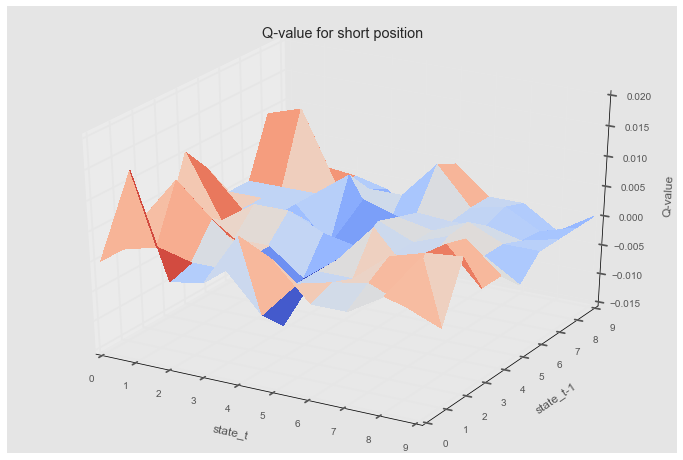

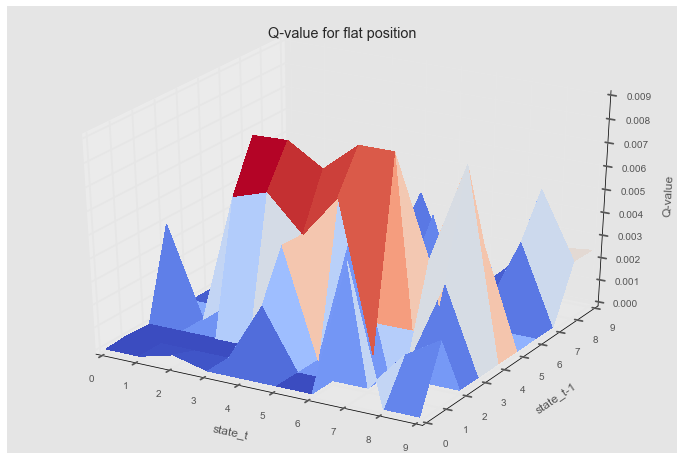

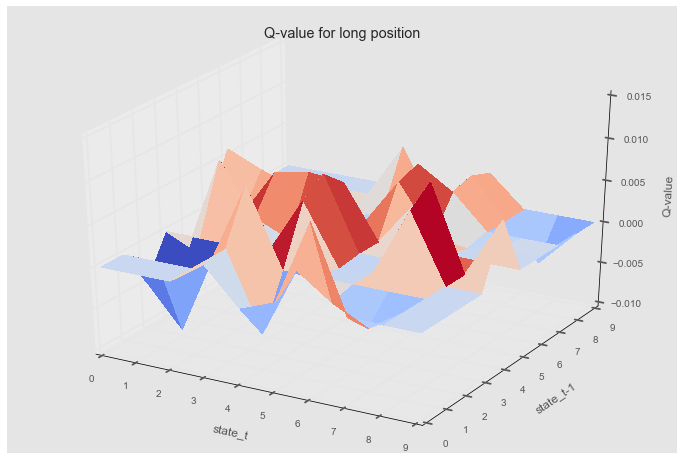

In [181]:
#plot Q-value matrix
def plot_Q_matrix_3d(Q,nb_states,nb_actions):
    """Credit to nekopuni"""
    x = np.linspace(0,nb_states-1,nb_states)
    y = np.linspace(0,nb_states-1,nb_states)
    x,y = np.meshgrid(x, y)
    for i in range(nb_actions):
        if i == 0:
            position = "short"
        elif i == 1:
            position = "flat"
        elif i == 2:
            position =  "long"
        fig = plt.figure()
        ax = fig.gca(projection='3d')

        ax.set_xlabel("state_t")
        ax.set_ylabel("state_t-1")
        ax.set_zlabel("Q-value")
        ax.set_title("Q-value for " + position + " position")
        #ax.view_init(90, 90)
        urf = ax.plot_surface(x, y, model2_state.q[:, :, i], rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        plt.show()
plot_Q_matrix_3d(model2_state.q,model2_state.nb_states,model2_state.nb_actions)

### Monte Carlo

In [183]:
# no exploration 
model2_state.nmc = 1000
res = model2_state.monte_carlo()

#### Monte carlo Wealth for each T

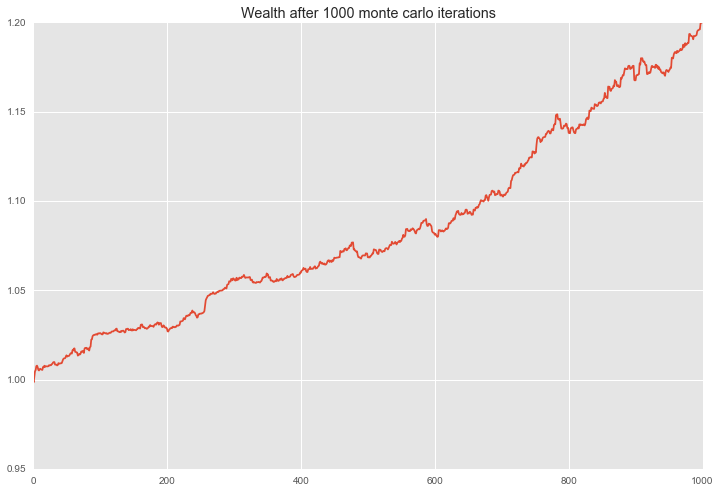

In [190]:
plt.plot(res[2].sum(axis = 0)/1000)
plt.title("Wealth after 1000 monte carlo iterations")
plt.